# wczytywanie danych
## normalizacja, podział na zbiory treningowe i testowe

In [ ]:
# Attribute Information:
# 1 - fixed acidity
# 2 - volatile acidity
# 3 - citric acid
# 4 - residual sugar
# 5 - chlorides
# 6 - free sulfur dioxide
# 7 - total sulfur dioxide
# 8 - density
# 9 - pH
# 10 - sulphates
# 11 - alcohol
# Output variable (based on sensory data):
# 12 - quality (score between 0 and 10)

In [58]:
# import libraries
import numpy as np
import pandas as pd
import copy

# path depends on where jupyter notebook was started from
import os
print(f'working directory: {os.getcwd()}')
RED_WINE_PATH = r'./wine-quality-classification/baza_danych/winequality-red.csv'
WHITE_WINE_PATH = r'./wine-quality-classification/baza_danych/winequality-white.csv'

# how much of all loaded samples will be designated as testing set (rest will be training set)
PERCENT_OF_SAMPLES_AS_TEST = 0.2

# will loaded data be normalized
NORMALIZE_DATA = True

ALL_CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
ALL_FEATURES_IDS = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


# define classes
class Wine:
    
    def __init__(self, name, filename, shuffle=False, asTest=PERCENT_OF_SAMPLES_AS_TEST, normalize=NORMALIZE_DATA):
        self.name = name
        self.true_column = 'quality'
        self.pred_column = 'predicted_quality'
        self.excluded_columns = [self.true_column, self.pred_column]
        with open(filename, 'rb') as f:
            data_csv = pd.read_csv (f, sep=';')
            self.df = pd.DataFrame(data_csv)
            self.df['predicted_quality'] = 0

            self.columns = list(self.df.columns)
            self.parameters = [c for c in self.columns if c not in self.excluded_columns]

            if shuffle:
                self.df = self.df.sample(frac = 1)
            
            self.split_to_train_test(asTest)

            if normalize:
                self.normalize()

            self.quantities = {}
            self.populated_classes = []
            for c in ALL_CLASSES:
                self.quantities[c] = len(self.df[self.df.quality.isin([c])])
                if self.quantities[c] > 0:
                    self.populated_classes.append(c)

            

    def split_to_train_test(self, asTest):
        self.train = self.df.copy()
        self.test = self.df.copy()
        train_count = int(len(self.df) * (1-asTest))
        self.train = self.train.drop(list(range(train_count+1, len(self.train))))
        self.test = self.test.drop(list(range(0, train_count)))

    def normalize(self):
        self.train, min_max_from_train = Wine.normalize_dataframe(self.train, excludeCols=self.excluded_columns)
        self.test, dont_care = Wine.normalize_dataframe(self.test, excludeCols=self.excluded_columns, minMax=min_max_from_train)

    def normalize_dataframe(df, excludeCols, minMax=None):
        if(minMax is None):
            minMax = {}
            for col in list(df.columns):
                _min = min(df[col])
                _max = max(df[col])
                minMax[col] = {'min': _min, 'max': _max}

        for col in list(df.columns):
            if col not in excludeCols:
                _min = minMax[col]['min']
                _max = minMax[col]['max']
                df[col] = df[col].apply(lambda x: (x-_min)/(_max-_min))
        return df, minMax

    def print_stats(self):
        

        print(f'{self.name} all samples    = {len(self.df)}')
        print(f'{self.name} train samples  = {len(self.train)}')
        print(f'{self.name} test samples   = {len(self.test)}')
        print(f'{self.name} sample quantity by class (quality): ')
        print(self.quantities)
        print(f'{self.name} populated classes: {self.populated_classes}')
        print()
        



working directory: F:\git


In [59]:
# load data

red_wine = Wine('red_wine', RED_WINE_PATH)
white_wine = Wine('white_wine', WHITE_WINE_PATH)

red_wine.print_stats()
white_wine.print_stats()


if red_wine.columns == white_wine.columns:
    FEATURES = red_wine.parameters
    print(f'features ({len(red_wine.parameters)}): \n {red_wine.parameters}')
else:
    print('error: different columns in files')





red_wine all samples    = 1599
red_wine train samples  = 1280
red_wine test samples   = 320
red_wine sample quantity by class (quality): 
{0: 0, 1: 0, 2: 0, 3: 10, 4: 53, 5: 681, 6: 638, 7: 199, 8: 18, 9: 0, 10: 0}
red_wine populated classes: [3, 4, 5, 6, 7, 8]

white_wine all samples    = 4898
white_wine train samples  = 3919
white_wine test samples   = 980
white_wine sample quantity by class (quality): 
{0: 0, 1: 0, 2: 0, 3: 20, 4: 163, 5: 1457, 6: 2198, 7: 880, 8: 175, 9: 5, 10: 0}
white_wine populated classes: [3, 4, 5, 6, 7, 8, 9]

features (11): 
 ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']


# Selekcja danych


In [40]:
print(white_wine.train['quality'].min())
print(red_wine.train['quality'].min())

3
3


In [41]:
print(white_wine.train['quality'].max())
print(red_wine.train['quality'].max())

9
8


In [42]:
from itertools import combinations
import math 

class FeatureSelector():
    def __init__(self):
        self.fisher_factors_fc = {}
        self.debug = True
        
    def euclidean_distance(self, row1, row2):
        return math.sqrt(
            sum([(row1[i] - row2[i]) ** 2 for i in range(len(row1))])
        )
    
    def get_mean_vector(self, train):
        
        return np.atleast_2d(train.mean(1)).T
    
    def get_covariance(self, dataset, mean):
        n = len(dataset[0])
        m = np.tile(mean, (1, n))
        
        x = np.subtract(dataset, m)
    
        return 1/(n-1) * np.dot(x, x.T)
    
    def get_fisher_factors(self, train_1,  train_2):
        mean_1 = self.get_mean_vector(train_1)
        mean_2 = self.get_mean_vector(train_2)
        
        covariance_1 = self.get_covariance(train_1, mean_1)
        covariance_2 = self.get_covariance(train_2, mean_2)
        
        return np.divide(self.euclidean_distance(mean_1, mean_2), np.trace(covariance_1 + covariance_2))
        
    
    def select(self, train, class_ids, feature_ids, number_of_features):
        # Dla podanej ilości cech utwórz wszystkie możliwe kombinacje
        features_combinations = list(combinations(feature_ids, number_of_features))
        class_combinatinos = list(combinations(class_ids, 2))
        
        # Wyznacz współczynniki Fishera dla każdej pary klas i każdej kombinacji cech
        for features_combination in features_combinations:
            fisher_factors = {}
            for class_combination in class_combinatinos:
                train_samples_1 = train.loc[train['quality'] == class_combination[0]].to_numpy()
                train_samples_2 = train.loc[train['quality'] == class_combination[1]].to_numpy()
                
                train_samples_1_t = train_samples_1[:, features_combination].T
                train_samples_2_t = train_samples_2[:, features_combination].T
                
                fisher_factors[class_combination] = self.get_fisher_factors(
                                                            train_samples_1_t, train_samples_2_t
                                                        )
            self.fisher_factors_fc[features_combination] = sum(fisher_factors.values()) / len(fisher_factors)
                
                
        
        # Określ która kombinacja cech jest najlepsza dla wybranych cech
        best_features = [key for key, value in self.fisher_factors_fc.items() if self.fisher_factors_fc[key] == max(self.fisher_factors_fc.values())]
        return best_features

In [56]:
# Select best features for white wine samples
class_ids = white_wine.populated_classes
number_of_features = 5

fs = FeatureSelector()
best_white_wine_features = fs.select(white_wine.train, class_ids, ALL_FEATURES_IDS, number_of_features)
best_white_wine_features = list(*best_white_wine_features)
print(best_white_wine_features)

[2, 3, 4, 7, 10]


In [57]:
# Select best features for red wine samples
class_ids = red_wine.populated_classes
number_of_features = 5

fs = FeatureSelector()
best_red_wine_features = fs.select(red_wine.train, class_ids, ALL_FEATURES_IDS, number_of_features)
best_red_wine_features = list(*best_red_wine_features)
print(best_red_wine_features)

[3, 4, 6, 9, 10]


# Klasyfikacja

In [46]:
from sklearn.neighbors import KNeighborsClassifier, NearestCentroid
from sklearn.metrics import accuracy_score, cohen_kappa_score, balanced_accuracy_score

def get_accuracy(y_true, y_pred):
    return accuracy_score(y_true, y_pred), cohen_kappa_score(y_true, y_pred), balanced_accuracy_score(y_true, y_pred)


# Train data with selected features (X)
white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

# Test data with selected features
white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
red_wine_test = red_wine.test.iloc[:, best_red_wine_features]

# Target values (y)
white_wine_target = white_wine.train['quality']
red_wine_target = red_wine.train['quality']

# Test target
test_white_wine_target = white_wine.test['quality']
test_red_wine_target = red_wine.test['quality']

def nearest_neighbor_classifier(train, target, test, test_target):
    neighbors = KNeighborsClassifier(n_neighbors=1)
    neighbors.fit(train, target)
    y_pred = neighbors.predict(test)

    y_true = test_target.to_numpy()
    
    acc = get_accuracy(y_true, y_pred)

    print(f'Accuracy Score: {acc[0]}\nCohen Kappa Score: {acc[1]}\nBalanced Accuracy Score: {acc[2]}')
    return y_pred 

def k_nearest_neighbor_classifier(k, train, target, test, test_target):
    neighbors = KNeighborsClassifier(n_neighbors=k)
    neighbors.fit(train, target)
    y_pred = neighbors.predict(test)
    
    y_true = test_target.to_numpy()
    
    acc = get_accuracy(y_true, y_pred)

    print(f'Accuracy Score: {acc[0]}\nCohen Kappa Score: {acc[1]}\nBalanced Accuracy Score: {acc[2]}')
    return y_pred  

def nearest_mean_classifier(train, target, test, test_target):
    clf = NearestCentroid()
    clf.fit(train, target)
    y_pred = clf.predict(test)
    
    y_true = test_target.to_numpy()
    
    acc = get_accuracy(y_true, y_pred)

    print(f'Accuracy Score: {acc[0]}\nCohen Kappa Score: {acc[1]}\nBalanced Accuracy Score: {acc[2]}')
    return y_pred  


from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def draw_confusion_matrix(y_true, y_pred, class_ids, title):
    cm = confusion_matrix(y_true, y_pred)

    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(title)
    plt.ylabel('Quality')
    plt.xlabel('Predicted quality')

    tick_marks = np.arange(len(class_ids))
    plt.xticks(tick_marks, class_ids, rotation=45)
    plt.yticks(tick_marks, class_ids)

    for i in range(len(class_ids)):
        for j in range(len(class_ids)):
            plt.text(j, i, str(cm[i][j]))
        
    plt.show()

In [48]:
# NN
print('NN White wine')
white_wine_pred = nearest_neighbor_classifier(white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)
print()
print('NN Red wine')
red_wine_pred = nearest_neighbor_classifier(red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

NN White wine
Accuracy Score: 0.4193877551020408
Cohen Kappa Score: 0.1305229149514756
Balanced Accuracy Score: 0.25304505659989446

NN Red wine
Accuracy Score: 0.478125
Cohen Kappa Score: 0.19522920306005653
Balanced Accuracy Score: 0.22140237213766625
C:\Users\adamko\miniconda3\envs\smpd\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


In [49]:
# Finding best feature combination
feature_ids = ALL_FEATURES_IDS
class_ids_white = white_wine.populated_classes
class_ids_red = red_wine.populated_classes
#for n in range(2, 9):    
#    number_of_features = n

#    fs = FeatureSelector()
#    best_white_wine_features = fs.select(white_wine.train, class_ids_white, feature_ids, number_of_features)
#    best_white_wine_features = list(*best_white_wine_features)
#    best_red_wine_features = fs.select(red_wine.train, class_ids_red, feature_ids, number_of_features)
#    best_red_wine_features = list(*best_red_wine_features)
    
    # Train data with selected features (X)
#    white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
#    red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

    # Test data with selected features
#    white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
#    red_wine_test = red_wine.test.iloc[:, best_red_wine_features]
    
    # NN
#    print(f'NN White wine - featutres: {best_white_wine_features}')
#    white_wine_pred = nearest_neighbor_classifier(white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)
#    print(f'NN Red wine - features: {best_red_wine_features}')
#    red_wine_pred = nearest_neighbor_classifier(red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

In [50]:
best_white_wine_features = [0, 2, 3, 4, 7, 10]
best_red_wine_features = [1, 3, 4, 6, 9, 10]

# Train data with selected features (X)
white_wine_train = white_wine.train.iloc[:, best_white_wine_features]
red_wine_train = red_wine.train.iloc[:, best_red_wine_features]

# Test data with selected features
white_wine_test = white_wine.test.iloc[:, best_white_wine_features]
red_wine_test = red_wine.test.iloc[:, best_red_wine_features]

# Target values (y)
white_wine_target = white_wine.train['quality']
red_wine_target = red_wine.train['quality']

# Test target
test_white_wine_target = white_wine.test['quality']
test_red_wine_target = red_wine.test['quality']

In [46]:
# Red wine best number of neighbors (BEST k = 10)
# for i in range(1, 21):
    # print(f'k:{i}')
    # k_nearest_neighbor_classifier(i, red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

In [45]:
# White wine best number of neighbors (BEST k = 19)
#for i in range(1, 21):
    #print(f'k:{i}')
    #k_nearest_neighbor_classifier(i, white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)

# NM

In [48]:
# nn

NM White wine - featutres: [0, 1, 2, 3, 4, 6, 7, 10]
Accuracy Score: 0.30612244897959184
Cohen Kappa Score: 0.13299272333178525
Balanced Accuracy Score: 0.42963566367209854

NM Red wine - featutres: [0, 1, 2, 3, 4, 6, 7, 10]
Accuracy Score: 0.378125
Cohen Kappa Score: 0.21695932320102307
Balanced Accuracy Score: 0.4239750445632799


C:\Users\janje\miniconda3\envs\smpd\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


# kNN

In [ ]:
# k-nn

# NM

NM White wine - featutres: [2, 3, 4, 7, 10]
Accuracy Score: 0.25612244897959185
Cohen Kappa Score: 0.09869766467798646
Balanced Accuracy Score: 0.1870283094660704

NM Red wine - featutres: [2, 3, 4, 7, 10]
Accuracy Score: 0.35
Cohen Kappa Score: 0.15650741350906094
Balanced Accuracy Score: 0.269129644864939
C:\Users\adamko\miniconda3\envs\smpd\lib\site-packages\sklearn\metrics\_classification.py:1850: UserWarning: y_pred contains classes not in y_true
  warnings.warn('y_pred contains classes not in y_true')


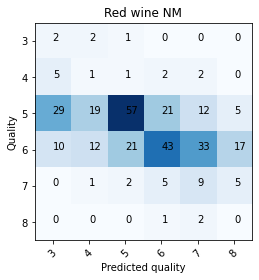

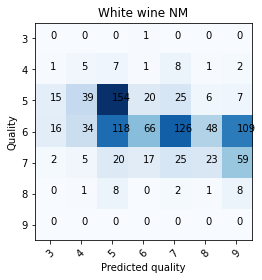

In [62]:
# nm
print(f'NM White wine - featutres: {best_white_wine_features}')
white_nm_prod = nearest_mean_classifier(white_wine_train, white_wine_target, white_wine_test, test_white_wine_target)
print()
print(f'NM Red wine - featutres: {best_white_wine_features}')
red_nm_prod = nearest_mean_classifier(red_wine_train, red_wine_target, red_wine_test, test_red_wine_target)

draw_confusion_matrix(test_red_wine_target.to_numpy(), red_nm_prod, class_ids_red, 'Red wine NM')
draw_confusion_matrix(test_white_wine_target.to_numpy(), white_nm_prod, class_ids_white, 'White wine NM')

# Wnioski (?)